In [17]:
from scipy.sparse import *
import numpy as np
import pickle
import random
from sklearn.decomposition import PCA
%matplotlib inline
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from operator import itemgetter
from scipy.sparse import csc_matrix as smatrix
import scipy

In [4]:
# load vocabulary
with open('vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)
list(vocab.items())[:10]

[('turn', 723),
 ('massacre', 14203),
 ('paste', 5865),
 ('ancor', 20867),
 ('aid', 4494),
 ('ipl', 19855),
 ('enjoy', 506),
 ('stilll', 9115),
 ('kathleen', 14283),
 ('bish', 13498)]

In [5]:
# construct num -> word dict
reverse_dictionary = dict(zip(vocab.values(), vocab.keys()))

In [6]:
# file -> [[word_number_1_1, ..., word_number_1_K1], ..., [word_number_L_1, ..., word_number_L_KL]]
def file_to_word2numbers(filename):
    data = open(filename, 'rb')
    word2numbers_all = []
    for line in tqdm(data):
        line = line.strip().decode("utf-8").split(' ')
        word2numbers = []
        for word in line:
            if word in vocab: word2numbers.append(vocab[word])
        if word2numbers:
            word2numbers_all.append(word2numbers)
    return word2numbers_all

In [7]:
# loading data -> numbers of words
pos_numbers = file_to_word2numbers('../data/train_pos.txt')
neg_numbers = file_to_word2numbers('../data/train_neg.txt')

100000it [00:00, 106461.33it/s]
100000it [00:01, 78637.93it/s]


In [8]:
# number of word occurences as embeddings (basic embeddings)
def numbers_to_dataset(numbers):
    tweets_embeddings = np.zeros((len(numbers), len(vocab)), dtype=np.float32)
    for i, tweet in tqdm(enumerate(numbers)):
        for number in tweet:
            tweets_embeddings[i, number] += 1
    return smatrix(tweets_embeddings)

In [9]:
# applying it to numbers
pos_data = numbers_to_dataset(pos_numbers)
neg_data = numbers_to_dataset(neg_numbers)

99995it [00:05, 19700.87it/s]
99996it [00:06, 16293.11it/s]


In [10]:
np.sum(pos_data[0,:])

27.0

In [14]:
np.vstack((pos_data, neg_data))

array([[ <99995x21161 sparse matrix of type '<class 'numpy.float32'>'
	with 1251129 stored elements in Compressed Sparse Column format>],
       [ <99996x21161 sparse matrix of type '<class 'numpy.float32'>'
	with 1454308 stored elements in Compressed Sparse Column format>]], dtype=object)

In [15]:
# constructing X, y pair
def two_datasets_to_one(pos_data, neg_data):
    assert pos_data.shape[1] == neg_data.shape[1]
    X = scipy.sparse.vstack((pos_data, neg_data))
    y = np.array([1] * pos_data.shape[0] + [0] * neg_data.shape[0])
    assert len(y) == X.shape[0]
    assert X.shape[0] == pos_data.shape[0] + neg_data.shape[0]
    assert X.shape[1] == pos_data.shape[1]
    return X, y

In [ ]:
# applying to datasets (pos & neg)
X, y = two_datasets_to_one(pos_data, neg_data)

In [22]:
clf = LogisticRegression(verbose=True, n_jobs = 8, solver = 'sag', tol = 0.001, C = 1000, max_iter = 100000)
clf.fit(X, y)

convergence after 361 epochs took 90 seconds


[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:  1.5min finished


LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100000, multi_class='ovr',
          n_jobs=8, penalty='l2', random_state=None, solver='sag',
          tol=0.001, verbose=True, warm_start=False)

0.859543679466


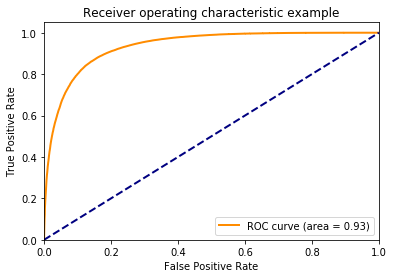

In [23]:
print(clf.score(X, y))

fpr, tpr, _ = roc_curve(y, clf.predict_proba(X)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [28]:
# open train and predict
def test_to_dataset(filename):
    data = open(filename, 'rb')
    idxes = []
    tweets_embeddings = []
    
    for line in tqdm(data):
        idx, line = line.strip().decode("utf-8").split(',', 1)
        idxes.append(idx)
        line = line.split(' ')
        tweet = []
        
        tweet_embeddings = np.zeros((len(vocab), ), dtype=np.float32)
        
        for word in line:
            if word in vocab:
                tweet.append(vocab[word])
                tweet_embeddings[vocab[word]] += 1
                
        tweets_embeddings.append(tweet_embeddings)
        
    #return tweets_embeddings
    tweets_embeddings = np.array(tweets_embeddings)
    assert len(idxes) == tweets_embeddings.shape[0]
    assert tweets_embeddings.shape[1] == len(vocab)
    return idxes, tweets_embeddings

In [29]:
idx_test, X_test = test_to_dataset('../data/test_data.txt')

10000it [00:00, 12503.95it/s]


In [30]:
y_predicted = np.array(2 * (clf.predict(X_test) - 0.5), dtype=np.int64)

In [31]:
answers = sorted(zip(idx_test, y_predicted), key = lambda x: int(x[0]))

In [32]:
f = open('submission_count.txt', 'w')
f.write("Id,Prediction\n")
for idx, ans in answers:
    f.write("%s,%s\n" % (idx, ans))
f.close()